In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.model_selection import KFold,cross_val_score

In [2]:
plt.style.use("seaborn-whitegrid")

# set the auc metric
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

In [3]:
# load the data
df_unnorm = pd.read_csv('unnormalized_train.csv', index_col=0)
df_norm = pd.read_csv('normalized_train.csv')

In [4]:
df_unnorm.head()

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,72.0,0,0,0,0,0,0,0,0,1,999,0,0,-1.8,93.075,-47.1,1.453,5099.1,0
1,30.0,1,1,1,0,1,0,1,1,1,999,0,0,-1.7,94.027,-38.3,0.886,4991.6,0
2,31.0,2,0,1,0,1,0,1,1,4,999,0,0,1.4,93.444,-36.1,4.966,5228.1,0
3,37.0,1,0,2,0,1,1,1,2,1,999,0,0,-3.4,92.649,-30.1,0.722,5017.5,0
4,53.0,2,2,3,1,0,0,0,3,2,999,0,0,1.1,93.994,-36.4,4.860,5191.0,0


In [5]:
df_norm.head()

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,72.0,0,0,0,0,0,0,0,0,1,999,0,0,0.333333,0.340608,0.154812,0.185672,0.512287,0
1,30.0,1,1,1,0,1,0,1,1,1,999,0,0,0.354167,0.711613,0.523013,0.057130,0.105860,0
2,31.0,2,0,1,0,1,0,1,1,4,999,0,0,1.000000,0.484412,0.615063,0.982090,1.000000,0
3,37.0,1,0,2,0,1,1,1,2,1,999,0,0,0.000000,0.174591,0.866109,0.019950,0.203781,0
4,53.0,2,2,3,1,0,0,0,3,2,999,0,0,0.937500,0.698753,0.602510,0.958059,0.859735,0


In [4]:
#################### Unnormalized data ####################
# Splitting the data into train and test
X_train_un, X_test_un, y_train, y_test = train_test_split(df_unnorm.iloc[:,:-1], df_unnorm.iloc[:,-1], test_size=0.2, random_state=42)

# use filter method to select the important features
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train_un, y_train)
important_features_idx = selector.get_support()
important_features = np.where(important_features_idx)[0]
print("Important features are:", df_unnorm.columns[important_features])

# select the important features as the input of the model
X_train_selected_un = X_train_un.iloc[:,important_features]
X_test_selected_un = X_test_un.iloc[:,important_features]

Important features are: Index(['default', 'contact', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [5]:
#################### Normalized data ####################
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1], test_size=0.2, random_state=42)

# use filter method to select the important features
selector = SelectKBest(f_classif, k=10)
selector.fit(X_train, y_train)
important_features_idx = selector.get_support()
important_features = np.where(important_features_idx)[0]
print("Important features are:", df_unnorm.columns[important_features])

# select the important features as the input of the model
X_train_selected = X_train.iloc[:,important_features]
X_test_selected = X_test.iloc[:,important_features]

Important features are: Index(['default', 'contact', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


# Decision Tree

Normalized data with feature selection

In [8]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Set the parameters
param_grid = {'min_samples_split': range(20, 201, 10),  # from 20 to 200 with step 10
                'min_samples_leaf': range(10, 101, 10),
                'max_depth': range(1, 11)}  # try max_depth from 1 to 10

# Use grid search to find the best parameters
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(grid_search, X_train_selected, y_train, cv=5, scoring=auc_scorer)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

# Print the best parameters, accuracy and the best auc score
print(f"The best max_depth：{grid_search.best_params_['max_depth']}")
print(f"The best min_samples_split：{grid_search.best_params_['min_samples_split']}")
print(f"The best min_samples_leaf：{grid_search.best_params_['min_samples_leaf']}")
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

The best max_depth：10
The best min_samples_split：40
The best min_samples_leaf：10
The accuracy on the training set：0.8665584873923116
Mean AUC score of the ROC curve: 0.93


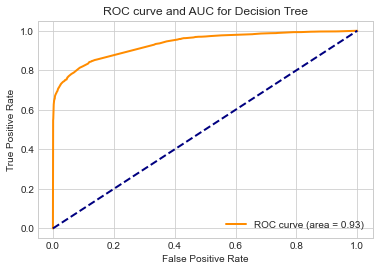

In [9]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test_selected)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for Decision Tree')
plt.legend(loc="lower right")
plt.show()

In [10]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.8624714234147516


# Linear Perceptron

Normalized data with feature selection

In [16]:
# Linear perceptron Classifier
clf = Perceptron(random_state=42)

# Set the parameters
param_grid = {
    'eta0': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [10, 50, 100, 200, 500, 1000],
}

# Use grid search to find the best hyperparameter combination
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=False, needs_threshold=True)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

# Print the best parameter combination, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))


The best parameters found:  {'eta0': 0.0001, 'max_iter': 50}
The accuracy on the training set：0.5498320775687341
Mean AUC score of the ROC curve: 0.65


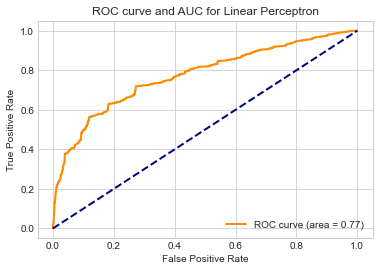

In [17]:
# plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.decision_function(X_test_selected))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for Linear Perceptron')
plt.legend(loc="lower right")
plt.show()


In [18]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.5941523282396823


# Linear Regression

Normalized data without feature selection

In [26]:
auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

In [28]:
# Logistic Regression Classifier
lr = LogisticRegression(solver='liblinear',max_iter=1000, random_state=42)

# Set the parameters
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2']
}

# Use grid search to find the best hyperparameter combination
grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(grid_search, X_train, y_train, cv=5, scoring=auc_scorer)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

#  Print the best parameter combination, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

The best parameters found:  {'C': 0.3593813663804626, 'penalty': 'l1'}
The accuracy on the training set：0.7508950931158906
Mean AUC score of the ROC curve: 0.83


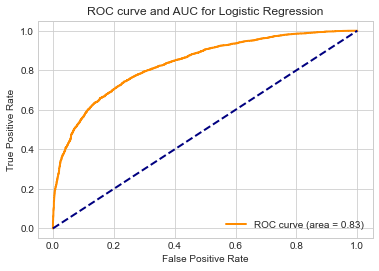

In [31]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

# SVM 

Normalized data without feature selection

In [6]:
# SVM Classifier
svc = SVC(kernel='rbf', probability=True)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))
}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=50)
grid_search.fit(X_train, y_train)

# Print the best parameter, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")

The best parameters found:  {'C': 100, 'gamma': 0.1}
The accuracy on the training set：0.88346425337614


In [6]:
best_svc = SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
best_svc.fit(X_train, y_train)

SVC(C=100, gamma=0.1, probability=True)

In [12]:
# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(best_svc, X_train, y_train, cv=5, scoring=auc_scorer, n_jobs=-1)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

Mean AUC score of the ROC curve: 0.94


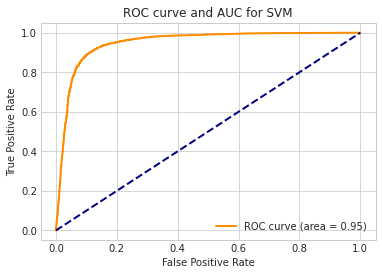

In [7]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for SVM')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.8913488148237276


# Naïve Bayes

Unnormalized data without feature selection

In [22]:
# Naive Bayes Classifier
gnb = GaussianNB()

param_grid = {'priors': [None, [0.2, 0.8], [0.4, 0.6], [0.6, 0.4], [0.8, 0.2]]}
grid_search = GridSearchCV(gnb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_un, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(grid_search, X_train_un, y_train, cv=5, scoring=auc_scorer)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

# Print the best parameter, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

The best parameters found:  {'priors': [0.6, 0.4]}
The accuracy on the training set：0.7484283305633576
Mean AUC score of the ROC curve: 0.83


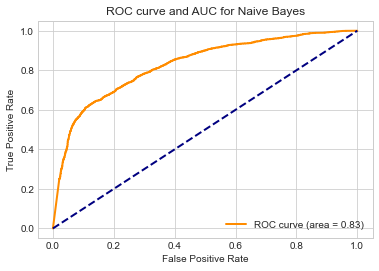

In [24]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test_un)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test_un)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.7527373360606425


# KNN

Normalized data with feature selection

In [14]:
# KNN Classifier
knn = KNeighborsClassifier()

# Set the parameters
param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Use grid search to find the best hyperparameter combination
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_selected, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(grid_search, X_train_selected, y_train, cv=5, scoring=auc_scorer)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

# Print the best parameter, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

The best parameters found:  {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
The accuracy on the training set：0.8849381592266438
Mean AUC score of the ROC curve: 0.91


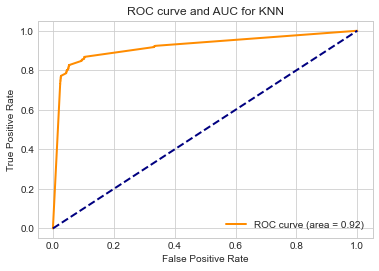

In [15]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test_selected)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for KNN')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.8870172061123812


# Ensemble methods

# Adaboost

Normalized data without feature selection

In [14]:
# AdaBoost Classifier
# Set the parameters
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 1, 10]
}

# Use grid search to find the best hyperparameter combination
grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(grid_search, X_train, y_train, cv=5, scoring=auc_scorer)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

# Print the best parameter, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

The best parameters found:  {'learning_rate': 1, 'n_estimators': 500}
The accuracy on the training set：0.8708600670839095
Mean AUC score of the ROC curve: 0.94


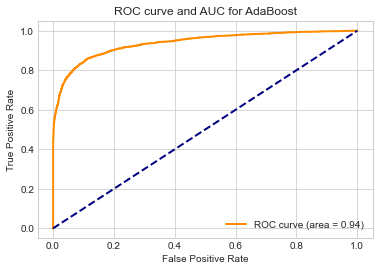

In [16]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for AdaBoost')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.8719768980868728


# Bagging

Normalized data without feature selection

In [20]:
# Bagging Classifier
# Set the parameters
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_samples': [0.1, 0.5, 1.0],
    'max_features': [0.1, 0.5, 1.0]
}

# Use grid search to find the best hyperparameter combination
grid_search = GridSearchCV(BaggingClassifier(random_state=42), param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Calculate the auc score under 5-fold cross validation
auc_scores = cross_val_score(grid_search, X_train, y_train, cv=5, scoring=auc_scorer)

# Calculate the mean auc score
mean_auc = np.mean(auc_scores)

# Print the best parameter, the accuracy and the best auc score
print("The best parameters found: ", grid_search.best_params_)
print(f"The accuracy on the training set：{grid_search.best_score_}")
print("Mean AUC score of the ROC curve: {:.2f}".format(mean_auc))

The best parameters found:  {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
The accuracy on the training set：0.9315044887001095
Mean AUC score of the ROC curve: 0.97


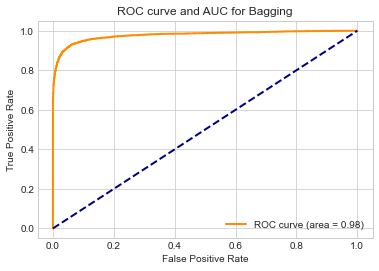

In [21]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for Bagging')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Evaluate the model on test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy on test set：{test_accuracy}")

The accuracy on test set：0.9322584526531104


---

# Prediction

In [24]:
test_set = pd.read_csv('normalized_test.csv')
X_pred_selected = test_set.iloc[:,important_features]

In [29]:
# check if there is any missing value
has_null = X_pred_selected.isnull().any().any()

if has_null:
    print("DataFrame contains missing values.")
else:
    print("DataFrame has no missing values.")

DataFrame has no missing values.


In [30]:
# compute the number of missing values in each column
null_count = X_pred_selected.isnull().sum()

# compute the total number of missing values
total_null_count = null_count.sum()

print("Number of missing values in each column:")
print(null_count)
print("Total number of missing values in the DataFrame:", total_null_count)

# locate the rows with missing values
for col in  X_pred_selected.columns:
    # get the rows with missing values for the column
    null_rows = X_pred_selected[X_pred_selected[col].isnull()].index
    
    if not null_rows.empty:
        print(f"Column '{col}' has missing values at row(s): {list(null_rows)}")

Number of missing values in each column:
default           0
contact           0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
euribor3m         0
nr.employed       0
dtype: int64
Total number of missing values in the DataFrame: 0


## KNN pred

In [20]:
best_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=4, weights='distance')
best_knn.fit(X_train_selected, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=4, weights='distance')

In [21]:
# use KNN to calculate the ranking score of test set
X_pred_selected['ranking_score'] = best_knn.predict_proba(X_pred_selected)[:, 1]
# select the ranking score as a single column
result = X_pred_selected[['ranking_score']]

# save the ranking score to csv file
result.to_csv('ranking_score.csv', index=False)

<ipython-input-21-17911ca0d904>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred_selected['ranking_score'] = best_knn.predict_proba(X_pred_selected)[:, 1]


## SVM pred

In [46]:
# use SVM to calculate the ranking score of test set
test_set['ranking_score'] = best_svc.predict_proba(test_set)[:, 1]
# select the ranking score as a single column
result = test_set[['ranking_score']]

# save the ranking score to csv file
result.to_csv('ranking_score.csv', index=False)

## Bagging pred

In [25]:
# use SVM to calculate the ranking score of test set
test_set['ranking_score'] = best_svc.predict_proba(test_set)[:, 1]
# select the ranking score as a single column
result = test_set[['ranking_score']]

# save the ranking score to csv file
result.to_csv('ranking_score.csv', index=False)